# Setup

In [2]:
import numpy as np
import pandas as pd
from prophet import Prophet

In [3]:
import prophet as prpht
print('Prophet version:', prpht.__version__)

Prophet version: 1.1.6


## Peyton Manning Wikipedia visit data

In [4]:
man_df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
man_df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [5]:
#Adding NFL Sunday regressor
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
man_df['nfl_sunday'] = man_df['ds'].apply(nfl_sunday)

## Auckland Cycling & Weather

[Auckland Transport](https://at.govt.nz/) is the Auckland council-controlled organisation responsible for transport projects and services. Over the past few years it has developed a strategy to actively promote and enable cycling as an alternative to individual automobile, and has built a number of cycle paths across the city. The [Auckland Transport cycling and walking research and monitoring](https://at.govt.nz/cycling-walking/research-monitoring/) department is tasked with conducting research and monitoring on sustainable transportation solutions including cycling and walking. It has installed a total of 39 dedicated cycling (as of June 2018) counters accross the city (see interactive map below). 

The cycling counts data (initially available at the hourly interval) are provided by [Auckland Transport](https://at.govt.nz/) (see [the Auckland Transport cycling and walking research and monitoring website](https://at.govt.nz/cycling-walking/research-monitoring/)) and the hourly weather data are provided by the [National Institute for Water and Atmospheric research](http://www.niwa.co.nz) (NIWA Ltd) [CliFlo](https://cliflo.niwa.co.nz/) database. We used the Mangere Electronic Weather Station (EWS) station in this particular case.   


<Axes: >

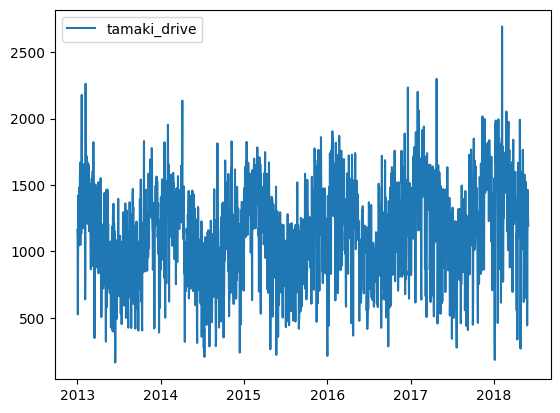

In [6]:
from glob import glob 

#Import year CSVs
lfiles = glob('DATA/CYCLING_AUCK_DATA/CYCLING_COUNTS/cycling_counts_????.csv')
lfiles.sort()

#Join
l = []
for f in lfiles:
    d = pd.read_csv(f, index_col=0, parse_dates=True)
    l.append(d)
auck_df = pd.concat(l, axis=0)
# auck_df.loc[:,['Tamaki Drive EB', 'Tamaki Drive WB']]

#Munging

## Adding Tamaki Drive EB & WB 
tamaki_df = auck_df.loc[:,'Tamaki Drive WB'] +  auck_df.loc[:,'Tamaki Drive EB']
## Removing missing data
tamaki_df = tamaki_df.loc['2013':'2018-06-01',].to_frame(name='tamaki_drive')
## Agg by date
tamaki_df = tamaki_df.groupby(tamaki_df.index.date).sum()

tamaki_df.plot()

In [7]:
#Weather Regressors

##Temperature
temp = pd.read_csv('DATA/CYCLING_AUCK_DATA/WEATHER/temp_day.csv', index_col=0, parse_dates=True)
temp = temp.loc[:,['Tmin(C)']]
temp.columns = ['temp']
# temp.head()

##Rainfall
rain = pd.read_csv('DATA/CYCLING_AUCK_DATA/WEATHER/rain_day.csv', index_col=0, parse_dates=True)
rain = rain.loc[:,['Amount(mm)']]
rain.columns = ['rain']

##Sunshine
sun = pd.read_csv('DATA/CYCLING_AUCK_DATA/WEATHER/sun_day.csv', index_col=0, parse_dates=True)
sun.columns = ['sun']

##Wind
wind = pd.read_csv('DATA/CYCLING_AUCK_DATA/WEATHER/wind_day.csv', index_col=0, parse_dates=True)
wind = wind.loc[:,['Speed(m/s)']]
wind.columns = ['wind']

##Interpolate missing values
temp = temp.interpolate(method='linear')
rain = rain.interpolate(method='linear')
sun = sun.interpolate(method='linear')
wind = wind.interpolate(method='linear')

##Join
tamaki_df = tamaki_df\
    .join(temp, how='left')\
    .join(rain, how='left')\
    .join(sun, how='left')\
    .join(wind, how='left')

# Munging
tamaki_df = tamaki_df.reset_index()
tamaki_df = tamaki_df.rename(columns={'index': 'ds', 'tamaki_drive':'y'})
# tamaki_df.index = [np.datetime64(d) for d in tamaki_df.index]

tamaki_df

,ds,y,temp,rain,sun,wind
0,2013-01-01,1163.0,20.000000,0.000000,0.950000,6.100000
1,2013-01-02,1112.0,20.342857,0.000000,0.535714,4.428571
2,2013-01-03,527.0,16.278571,0.228571,0.014286,4.728571
3,2013-01-04,1045.0,17.635714,0.000000,0.742857,8.978571
4,2013-01-05,1422.0,19.592857,0.000000,0.964286,6.185714
...,...,...,...,...,...,...
1973,2018-05-28,1107.0,8.750000,0.000000,0.271429,3.200000
1974,2018-05-29,1464.0,7.764286,0.000000,0.671429,2.571429
1975,2018-05-30,1298.0,7.614286,0.000000,0.621429,2.378571
1976,2018-05-31,1239.0,8.192857,0.000000,0.678571,2.057143


In [8]:
from prophet.make_holidays import make_holidays_df

## Auckland holidays
auk_holidays = make_holidays_df(
    year_list=[2013 + i for i in range(6)], country='NZ', province='AUK'
)
auk_holidays.holiday.unique()

array(["New Year's Day", "Day after New Year's Day",
       "Day after New Year's Day (observed)", 'Waitangi Day',
       'Waitangi Day (observed)', 'Anzac Day', 'Good Friday',
       'Easter Monday', "Queen's Birthday", 'Labour Day', 'Christmas Day',
       'Christmas Day (observed)', 'Boxing Day',
       'Auckland Anniversary Day', "New Year's Day (observed)",
       'Anzac Day (observed)', 'Boxing Day (observed)'], dtype=object)

# Meta's Prophet

Prophet follows the `sklearn` model API. We create an instance of the `Prophet` class and then call its `fit` and `predict` methods. 

The input to Prophet is always a dataframe with two columns: `ds` and `y`. The `ds` (datestamp) column should be of a format expected by Pandas, ideally `YYYY-MM-DD` for a date or `YYYY-MM-DD HH:MM:SS` for a timestamp. The `y` column _must_ be numeric, and represents the measurement we wish to forecast. Additional regressors may be added with the `add_regressor()` model method (see below).

# Quickstart Example

Forecasting daily page views for a random page (Peyton Manning).

In [9]:
man_df.head()

,ds,y,nfl_sunday
0,2007-12-10,9.590761,0
1,2007-12-11,8.519590,0
2,2007-12-12,8.183677,0
3,2007-12-13,8.072467,0
4,2007-12-14,7.893572,0


In [10]:
# Fitting Prophet model
from prophet import Prophet
m = Prophet()
##Addl regressor
m.add_regressor('nfl_sunday')
m.fit(man_df)

12:58:21 - cmdstanpy - INFO - Chain [1] start processing
12:58:21 - cmdstanpy - INFO - Chain [1] done processing


## Creating Future Data

You can get a dataframe that extends into the future a specified number of days using the helper method `Prophet.make_future_dataframe`. By default it will also include the dates from the history

In [11]:
ftr_man_df = m.make_future_dataframe(periods=365)
ftr_man_df['nfl_sunday'] = ftr_man_df.ds.apply(nfl_sunday)
ftr_man_df.tail()

,ds,nfl_sunday
3265,2017-01-15,1
3266,2017-01-16,0
3267,2017-01-17,0
3268,2017-01-18,0
3269,2017-01-19,0


The predict method will assign each row in ftr_man_df a predicted value which it names `yhat`. If you pass in historical dates, it will provide an _in-sample fit_. The forecast object here is a new dataframe that includes a column `yhat` with the forecast, as well as columns for components and uncertainty intervals.

In [12]:
forecast = m.predict(ftr_man_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.431640,7.718097,9.089661
3266,2017-01-16,8.502434,7.733819,9.211984
3267,2017-01-17,8.290790,7.584732,9.000134
3268,2017-01-18,8.124329,7.402537,8.796908
3269,2017-01-19,8.137886,7.390208,8.850437


You can plot the forecast by calling the `Prophet.plot` method and passing in your forecast dataframe.

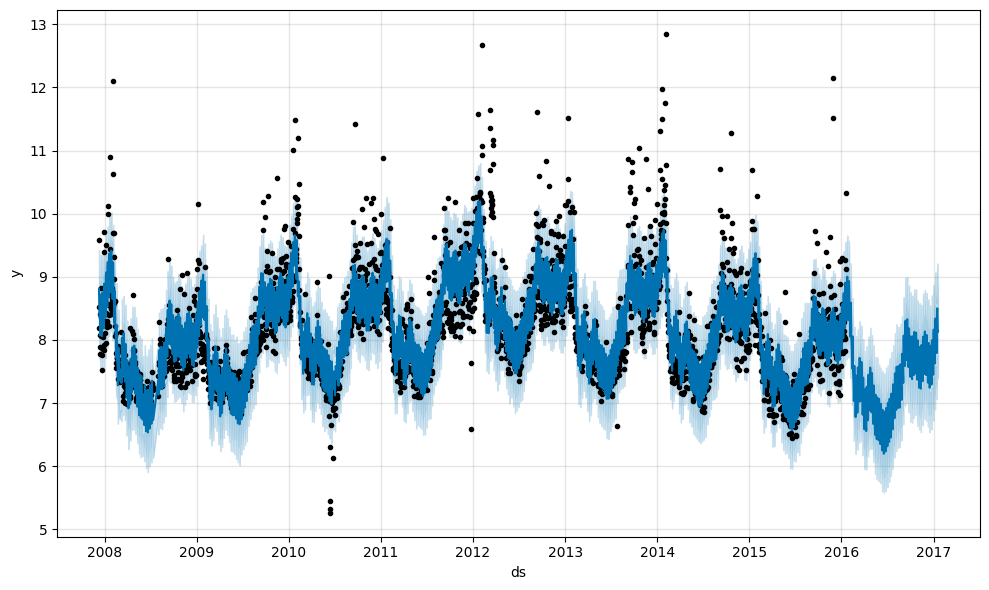

In [13]:
fig1 = m.plot(forecast)

If you want to see the forecast components, you can use the `Prophet.plot_components` method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

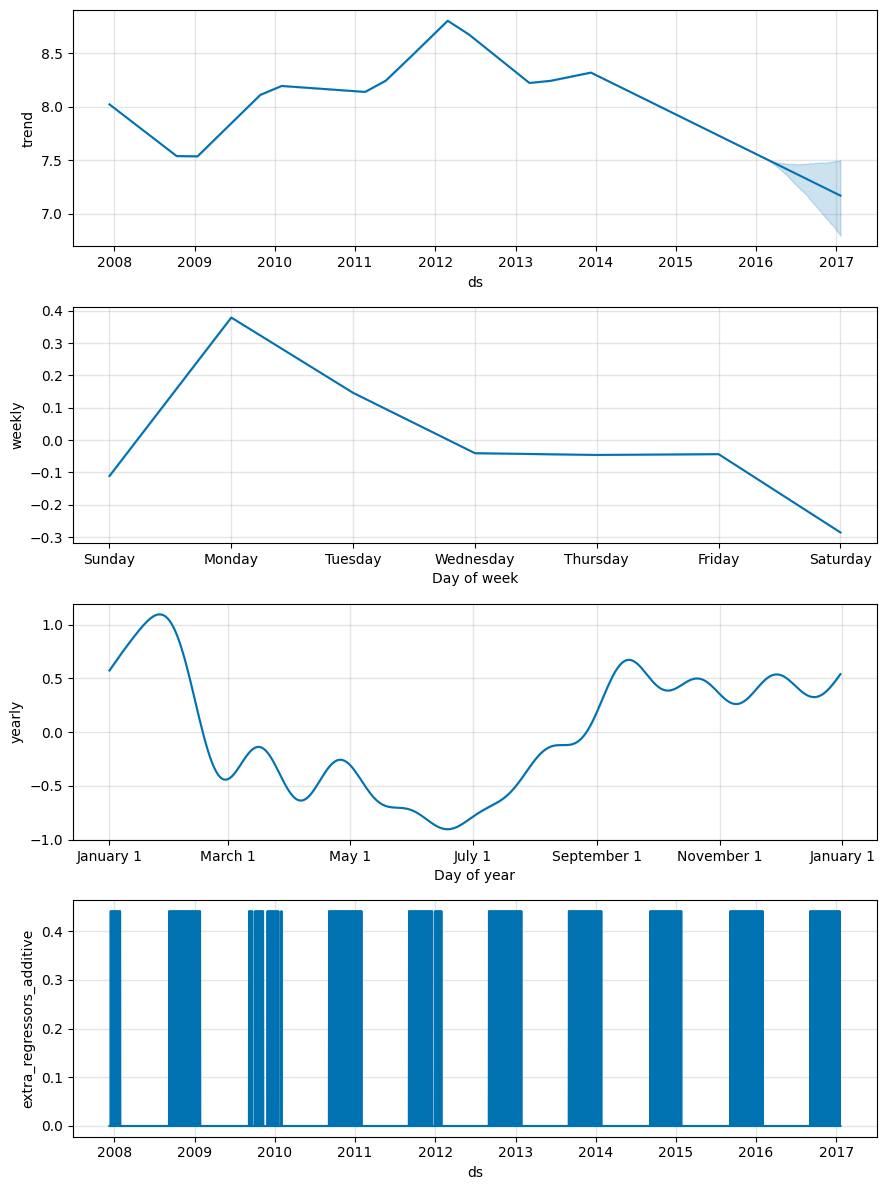

In [14]:
fig2 = m.plot_components(forecast)

In [15]:
#Interactive Plotly graph -- non functional
# from prophet.plot import plot_plotly, plot_components_plotly

# plot_plotly(m, forecast)

# Saturating Forecast

By default, Prophet uses a linear model for its forecast. When forecasting growth, there is usually some maximum achievable point: total market size, total population size, etc. This is called the _carrying capacity_, and the forecast should saturate at this point. Prophet allows you to make forecasts using a _logistic growth trend model_, with a specified carrying `cap`.

In [16]:
#Number of page visits to the R (programming language) Wiki page: https://en.wikipedia.org/wiki/R_%28programming_language%29
R_wiki_df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
R_wiki_df['cap'] = 8.5

We must specify the carrying capacity in a column cap. Here a particular value is assumed, but this would usually be set using data or expertise about the market size. Note that `cap` does _not_ need to be a constant. And, note that this capacity must be set for future DataFrames as well.

12:58:24 - cmdstanpy - INFO - Chain [1] start processing
12:58:24 - cmdstanpy - INFO - Chain [1] done processing


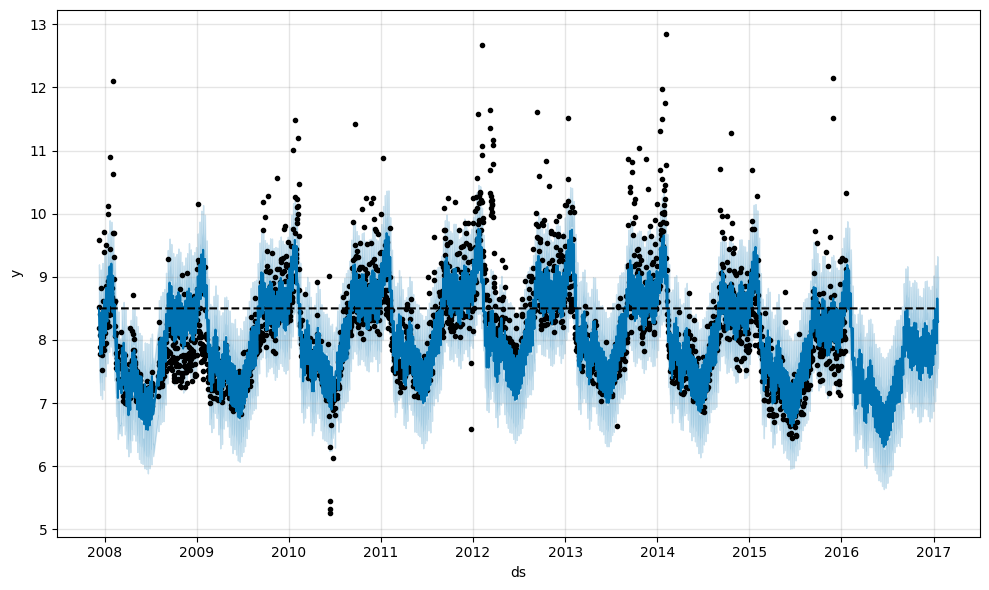

In [17]:
#Fitting the model
m = Prophet(growth='logistic')
m.fit(R_wiki_df)

#Future-casting
ftr_man_df = m.make_future_dataframe(periods=1*365)
ftr_man_df['cap'] = 8.5
fcst = m.predict(ftr_man_df)
fig = m.plot(fcst)

Note the dotted line to incicate the carrying capacity. The logistic growth model can also handle a saturating minimum with a column `floor`.

12:58:30 - cmdstanpy - INFO - Chain [1] start processing
12:58:30 - cmdstanpy - INFO - Chain [1] done processing


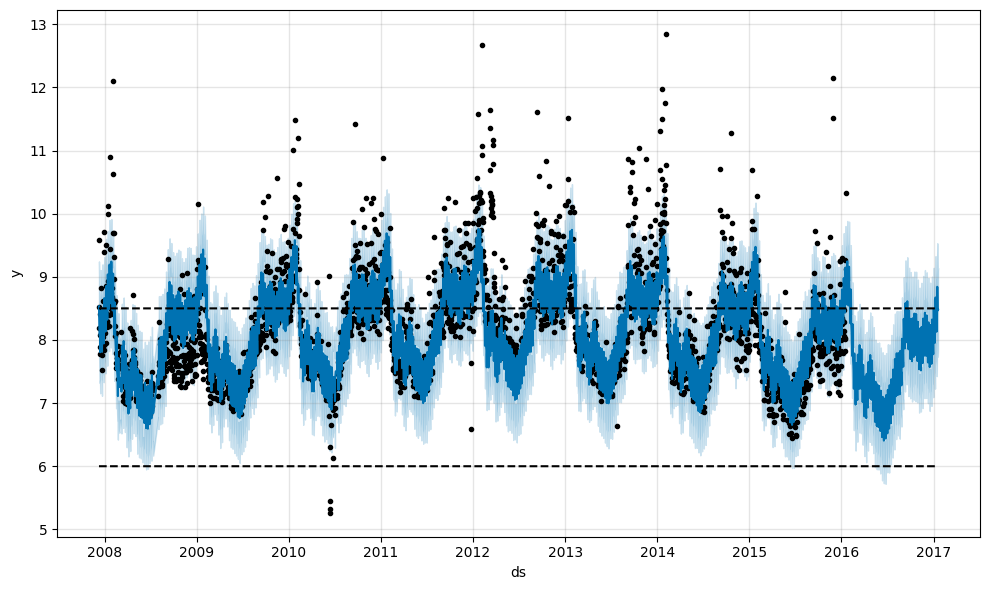

In [18]:
R_wiki_df['floor'] = 6
ftr_man_df['floor'] = 6
m = Prophet(growth='logistic')
m.fit(R_wiki_df)
fcst = m.predict(ftr_man_df)
fig = m.plot(fcst)

# Trend Changepoints

Real time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of possible places where the rate can change, but will use as few of them as possible. The locations of the signification changepoints can be visualized with:

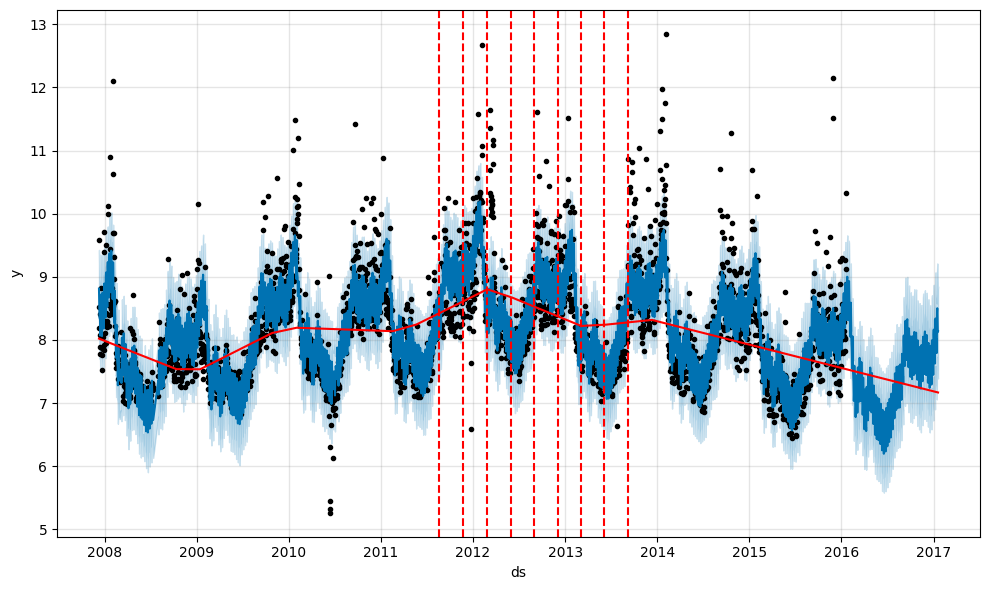

In [19]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

By default changepoints are only inferred for the first 80% of the time series in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series. This default works in many situations but not all, and can be changed using the `changepoint_range` argument. For example, `m = Prophet(changepoint_range=0.9)`.

However, if you wish to have finer control over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history), then there are several input arguments you can use. The number of potential changepoints can be set using the argument `n_changepoints`, but this is better tuned by adjusting the regularization.

## Manual Selection

If you wish, rather than using automatic changepoint detection you can manually specify the locations of potential changepoints with the `changepoints` argument. Slope changes will then be allowed only at these points, with the same sparse regularization as before. One could, for instance, create a grid of points as is done automatically, but then augment that grid with some specific dates that are known to be likely to have changes. As another example, the changepoints could be entirely limited to a small set of dates, as is done here:

12:58:36 - cmdstanpy - INFO - Chain [1] start processing
12:58:36 - cmdstanpy - INFO - Chain [1] done processing


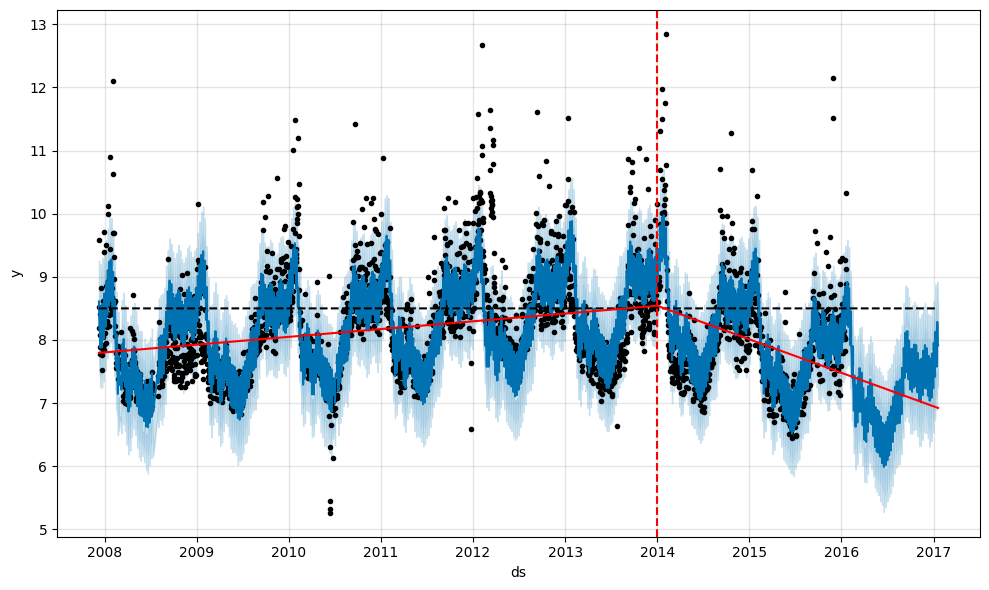

In [20]:
m = Prophet(changepoints=['2014-01-01'])
forecast = m.fit(man_df).predict(ftr_man_df)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

## Trend Flexibility

If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument `changepoint_prior_scale`. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible. Or, decreasing it will make the model less flexible (i.e., under-fit).

12:58:37 - cmdstanpy - INFO - Chain [1] start processing
12:58:37 - cmdstanpy - INFO - Chain [1] done processing


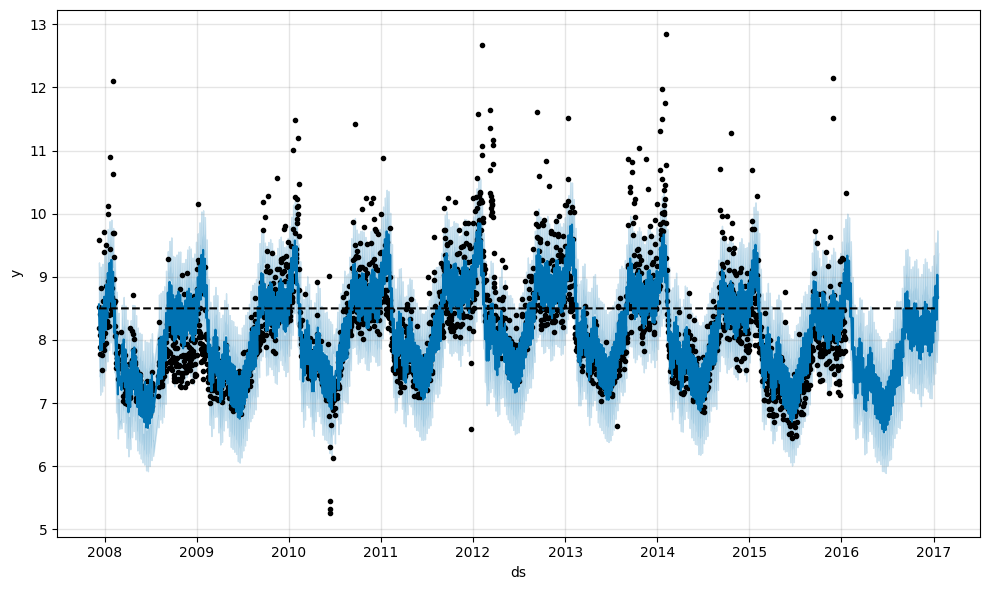

In [21]:
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(man_df).predict(ftr_man_df)
fig = m.plot(forecast)

When visualizing the forecast, this parameter can be adjusted as needed if the trend seems to be over- or under-fit. In the fully-automated setting, see the section on cross-validation for recommendations on how this parameter can be tuned.

# Holiday Effects

## Modeling Special Events

If you have holidays or other recurring events that you’d like to model, you must create a dataframe for them. It must have two columns (`holiday` and `ds`) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won’t repeat in the future, Prophet will model them and then not include them in the forecast.

You can also include columns lower_window and upper_window which extend the holiday out to `[lower_window, upper_window]` days around the date. For instance, if you wanted to include Christmas Eve in addition to Christmas you’d include `lower_window=-1, upper_window=0`. If you wanted to use Black Friday in addition to Thanksgiving, you’d include `lower_window=0, upper_window=1`. 

In [22]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))
holidays

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


Once the table is created, holiday effects are included in the forecast by passing them in with the `holidays` argument.

In [23]:
m = Prophet(holidays=holidays)
forecast = m.fit(man_df).predict(ftr_man_df)
#The holiday effect can be seen in the forecast dataframe:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'trend', 'playoff', 'superbowl']][-10:]

12:58:38 - cmdstanpy - INFO - Chain [1] start processing
12:58:39 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,playoff,superbowl
2190,2014-02-02,8.260698,1.217847,1.200633
2191,2014-02-03,8.259725,1.898839,1.455819
2532,2015-01-11,7.924788,1.217847,0.000000
2533,2015-01-12,7.923807,1.898839,0.000000
2901,2016-01-17,7.561064,1.217847,0.000000
2902,2016-01-18,7.560084,1.898839,0.000000
2908,2016-01-24,7.554202,1.217847,0.000000
2909,2016-01-25,7.553221,1.898839,0.000000
2922,2016-02-07,7.540476,1.217847,1.200633
2923,2016-02-08,7.539496,1.898839,1.455819


The holiday effects will also show up in the components plot, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl in the `holidays` components:

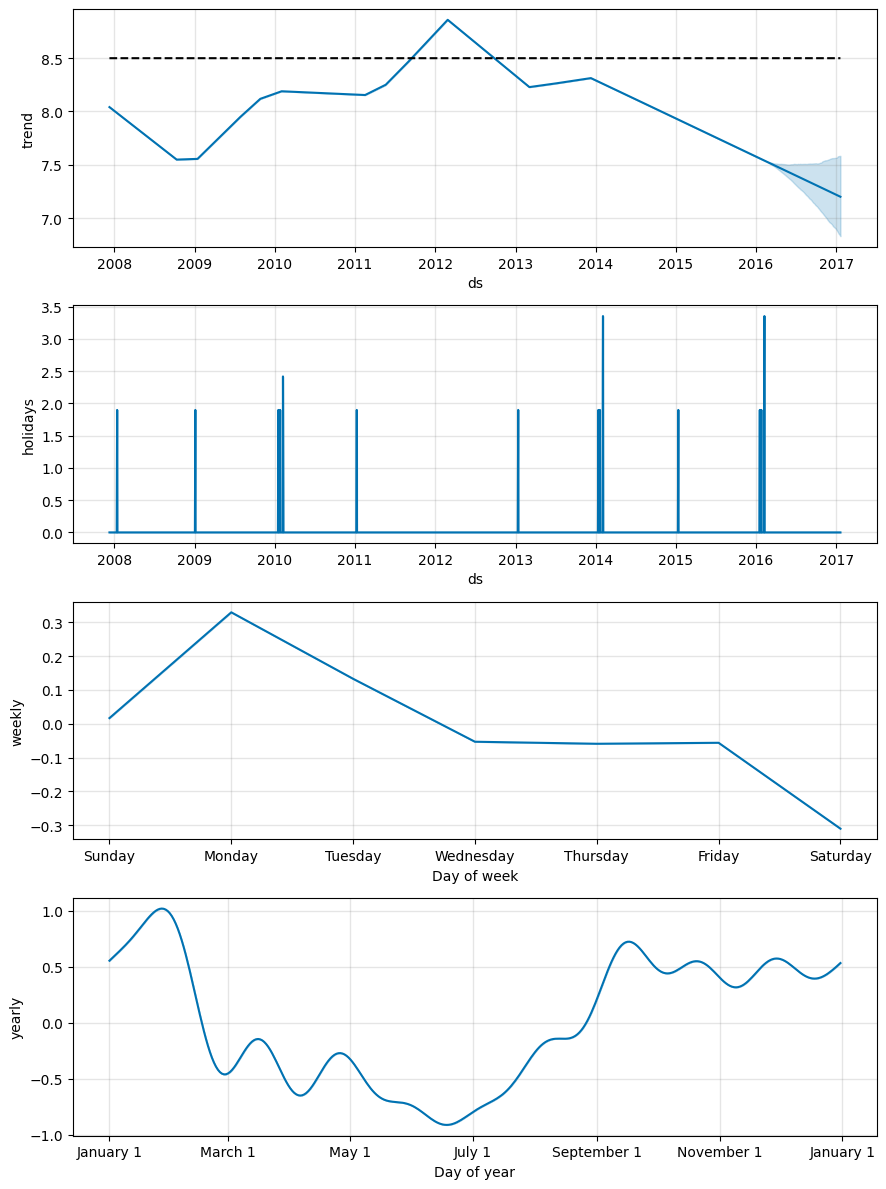

In [24]:
fig = m.plot_components(forecast)

## Built-in State Holidays

You can use a built-in collection of country-specific holidays using the `add_country_holidays` method. The name of the country is specified, and then major holidays for that country will be included in addition to any holidays that are specified via the `holidays` argument described above:

In [25]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(man_df)
#See included holidays with
m.train_holiday_names

12:58:40 - cmdstanpy - INFO - Chain [1] start processing
12:58:41 - cmdstanpy - INFO - Chain [1] done processing


0                         playoff
1                       superbowl
2                  New Year's Day
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Veterans Day
7                Thanksgiving Day
8                   Christmas Day
9        Christmas Day (observed)
10     Martin Luther King Jr. Day
11          Washington's Birthday
12                   Columbus Day
13        Veterans Day (observed)
14    Independence Day (observed)
15      New Year's Day (observed)
dtype: object

The holidays for each country are provided by the `holidays` package in Python. A list of available countries, and the country name to use, is available on their page: [https://github.com/vacanza/python-holidays/](https://github.com/vacanza/python-holidays/). Most holidays are computed deterministically and so are available for any date range; a warning will be raised if dates fall outside the range supported by that country.

The country holidays will also show up now on the `holidays` components

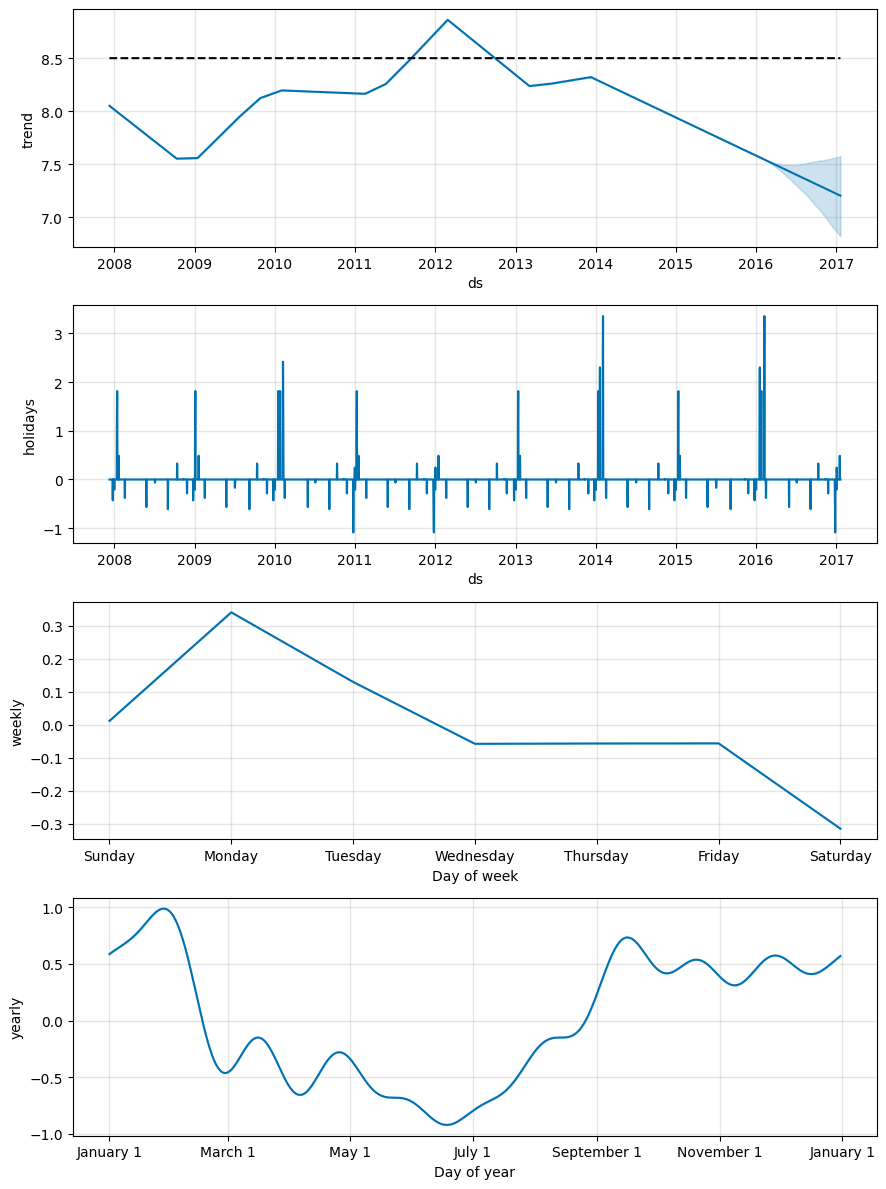

In [26]:
forecast = m.predict(ftr_man_df)
fig = m.plot_components(forecast)

## State & Province Holidays

Finally, state/province specific holidays that are available in the `holidays` library may be incorporated into a Prophet model with the utility function `make_holidays_df`

In [27]:
from prophet.make_holidays import make_holidays_df

ut_holidays = make_holidays_df(
    year_list=[2019 + i for i in range(10)], country='US', province='UT'
)
ut_holidays.holiday.unique()

array(["New Year's Day", 'Memorial Day', 'Independence Day', 'Labor Day',
       'Veterans Day', 'Thanksgiving Day', 'Christmas Day',
       'Martin Luther King Jr. Day', 'Columbus Day',
       'Washington and Lincoln Day', 'Pioneer Day',
       'Independence Day (observed)', "New Year's Day (observed)",
       'Juneteenth National Independence Day',
       'Juneteenth National Independence Day (observed)',
       'Christmas Day (observed)', 'Pioneer Day (observed)',
       'Veterans Day (observed)'], dtype=object)

## Overfit Holidays

It is possible that a handful of observations of past holidays can be over-fit by Prophet harming future prediction performance. If you find that the holidays are overfitting, you can adjust their _prior scale_ to smooth them using the parameter `holidays_prior_scale`. By default this parameter is `10`, which provides very little regularization. Reducing this parameter dampens holiday effects:

In [28]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(man_df)
forecast = m.predict(ftr_man_df)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

12:58:43 - cmdstanpy - INFO - Chain [1] start processing
12:58:44 - cmdstanpy - INFO - Chain [1] done processing


,ds,playoff,superbowl
2190,2014-02-02,1.206360,0.962841
2191,2014-02-03,1.851229,0.997293
2532,2015-01-11,1.206360,0.000000
2533,2015-01-12,1.851229,0.000000
2901,2016-01-17,1.206360,0.000000
2902,2016-01-18,1.851229,0.000000
2908,2016-01-24,1.206360,0.000000
2909,2016-01-25,1.851229,0.000000
2922,2016-02-07,1.206360,0.962841
2923,2016-02-08,1.851229,0.997293


Note that the holiday effect's magnitude has been reduced compared to before, especially for superbowls, which had the fewest observations.

Prior scales can be set separately for individual holidays by including a column `prior_scale` in the holidays dataframe. 

In [29]:
#Set prior scale for the Super Bowl only
holidays = holidays.assign(prior_scale=10)
holidays.loc[holidays.holiday == 'superbowl', 'prior_scale'] = 0.05

#Rebuild Prophet
m = Prophet(holidays=holidays).fit(man_df)
forecast = m.predict(ftr_man_df)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

/tmp/ipykernel_32548/1350494295.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  holidays.loc[holidays.holiday == 'superbowl', 'prior_scale'] = 0.05
12:58:44 - cmdstanpy - INFO - Chain [1] start processing
12:58:45 - cmdstanpy - INFO - Chain [1] done processing


,ds,playoff,superbowl
2190,2014-02-02,1.274973,0.901306
2191,2014-02-03,1.950110,0.924788
2532,2015-01-11,1.274973,0.000000
2533,2015-01-12,1.950110,0.000000
2901,2016-01-17,1.274973,0.000000
2902,2016-01-18,1.950110,0.000000
2908,2016-01-24,1.274973,0.000000
2909,2016-01-25,1.950110,0.000000
2922,2016-02-07,1.274973,0.901306
2923,2016-02-08,1.950110,0.924788


Note that now the superbowl holiday has been regularized, while the playoffs has been largely left the same as the original holiday effect weights.

# Seasonalities

By default, Prophet fits weekly & yearly sesaonalities as long as the corresponding cycles are at least 2 in length. And, if the data period is less than daily (i.e., hourly, by-the-minute) Prophet will also estimate daily seasonalities.

## Fourier Orders

Seasonalities are estimated using a partial Fourier sum. Partial Fourier sums can approximate arbitrary periodic signals. The number of terms in the partial sum (the _order_) is a parameter that determines how quickly the seasonality can change.

The default Fourier order for yearly seasonality is 10, which produces this fit:

12:58:45 - cmdstanpy - INFO - Chain [1] start processing
12:58:46 - cmdstanpy - INFO - Chain [1] done processing


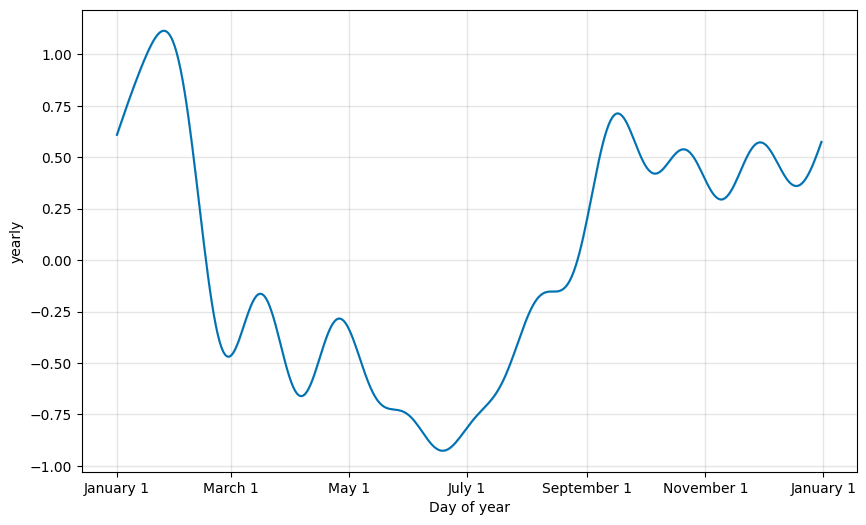

In [30]:
from prophet.plot import plot_yearly
m = Prophet().fit(man_df)
a = plot_yearly(m)

The default values are often appropriate, but they can be increased when the seasonality needs to fit higher-frequency changes, and generally be less smooth. The Fourier order can be specified for each built-in seasonality when instantiating the model, here `yearly_seasonality` is increased to 20.

12:58:47 - cmdstanpy - INFO - Chain [1] start processing
12:58:47 - cmdstanpy - INFO - Chain [1] done processing


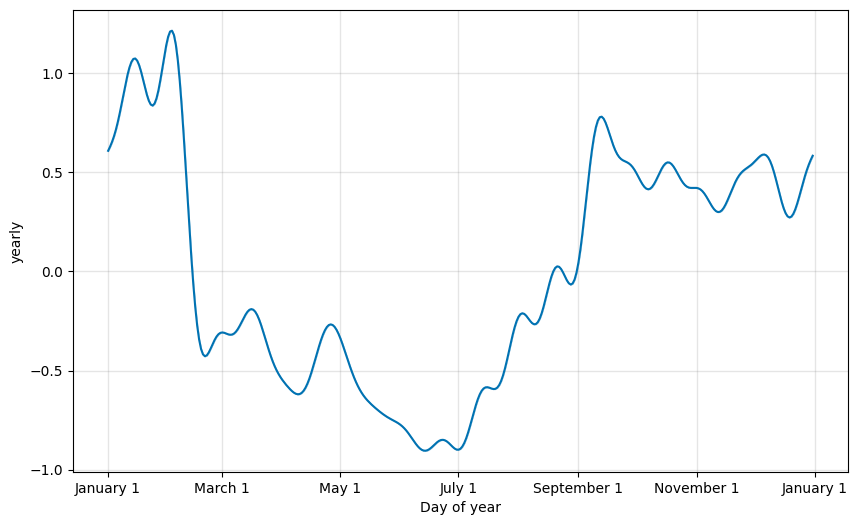

In [31]:
from prophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(man_df)
a = plot_yearly(m)

Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting: N Fourier terms corresponds to 2N variables used for modeling the cycle. 

Prophet will by default fit weekly and yearly seasonalities (as long as those cycles are at least 2 cycles long). Also by default, Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality. It will also fit daily seasonality for a sub-daily time series. 

## Custom Seasonality

Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long. It will also fit daily seasonality for a sub-daily time series. You can add other seasonalities (monthly, quarterly, hourly) using the `add_seasonality` method.

The inputs to this function are a name, the period of the seasonality in days, and the Fourier order for the seasonality. For reference, by default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality.

As an example, here we fit the Peyton Manning data, but replace the `weekly_seasonality` with `'monthly'` seasonality. The monthly seasonality then will appear in the components plot:

12:58:48 - cmdstanpy - INFO - Chain [1] start processing
12:58:48 - cmdstanpy - INFO - Chain [1] done processing


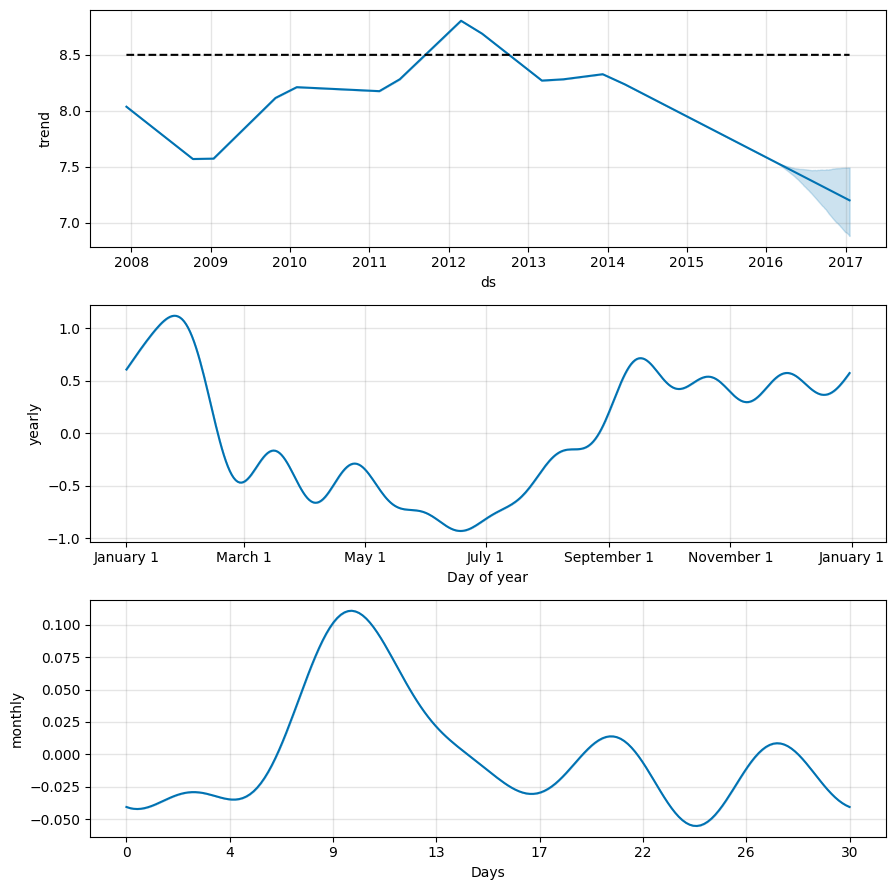

In [32]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(man_df).predict(ftr_man_df)
fig = m.plot_components(forecast)

### Seasonalities That Depend on Other Factors

In some instances the seasonality may depend on other factors, such as a weekly seasonal pattern that is different during the summer than it is during the rest of the year, or a daily seasonal pattern that is different on weekends vs. on weekdays. These types of seasonalities can be modeled using conditional seasonalities.

For example, consider the Peyton Manning traffic problem. The default weekly seasonality assumes that the pattern of weekly seasonality is the same throughout the year, but we’d expect the pattern of weekly seasonality to be different during the on-season (when there are games every Sunday) and the off-season. We can use conditional seasonalities to construct separate on-season and off-season weekly seasonalities.

First we add a boolean column to the dataframe that indicates whether each date is during the on-season or the off-season:

In [33]:
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)

man_df['on_season'] = man_df['ds'].apply(is_nfl_season)
man_df['off_season'] = ~man_df['ds'].apply(is_nfl_season)

Then we disable the built-in `weekly_seasonality`, and replace it with two weekly seasonalities that have these columns specified as a condition. This means that the seasonality will only be applied to dates where the `condition_name` column is `True`. We must also add the column to the future dataframe for which we are making predictions.

12:58:52 - cmdstanpy - INFO - Chain [1] start processing
12:58:53 - cmdstanpy - INFO - Chain [1] done processing


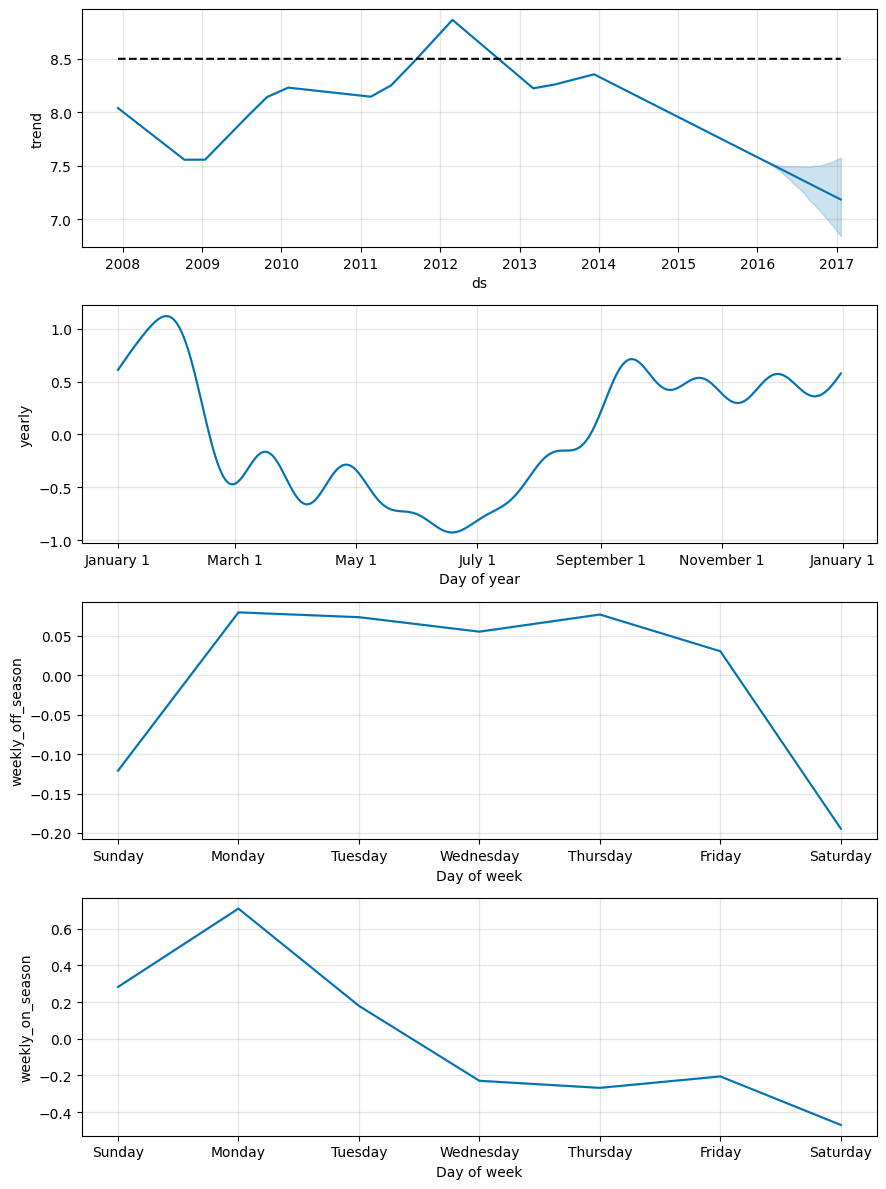

In [34]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season'
                  , period=7
                  , fourier_order=3
                  , condition_name='on_season')
m.add_seasonality(name='weekly_off_season'
                  , period=7
                  , fourier_order=3
                  , condition_name='off_season')

ftr_man_df['on_season'] = ftr_man_df['ds'].apply(is_nfl_season)
ftr_man_df['off_season'] = ~ftr_man_df['ds'].apply(is_nfl_season)
forecast = m.fit(man_df).predict(ftr_man_df)
fig = m.plot_components(forecast)

Both of the seasonalities now show up in the components plots above. We can see that during the on-season when games are played every Sunday, there are large increases on Sunday and Monday that are completely absent during the off-season.

## Overfit Seasonality

Although not likely, if all seasonality is suspected of overfitting (perhaps due to limited prior seasonal data), the overall _prior scale_ may be adjusted with `seasonality_prior_scale` in the `Prophet()` object. Prior scales for _individual_ seasonalities can be passed as an argument to `add_seasonality`. For instance, the prior scale for just weekly seasonality can be set using:

In [35]:
m = Prophet()
m.add_seasonality(
    name='weekly', period=7, fourier_order=3, prior_scale=0.1)

## Multiplicative Seasonality

By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. This time series of the number of air passengers is an example of when additive seasonality does not work:

12:58:54 - cmdstanpy - INFO - Chain [1] start processing
12:58:54 - cmdstanpy - INFO - Chain [1] done processing


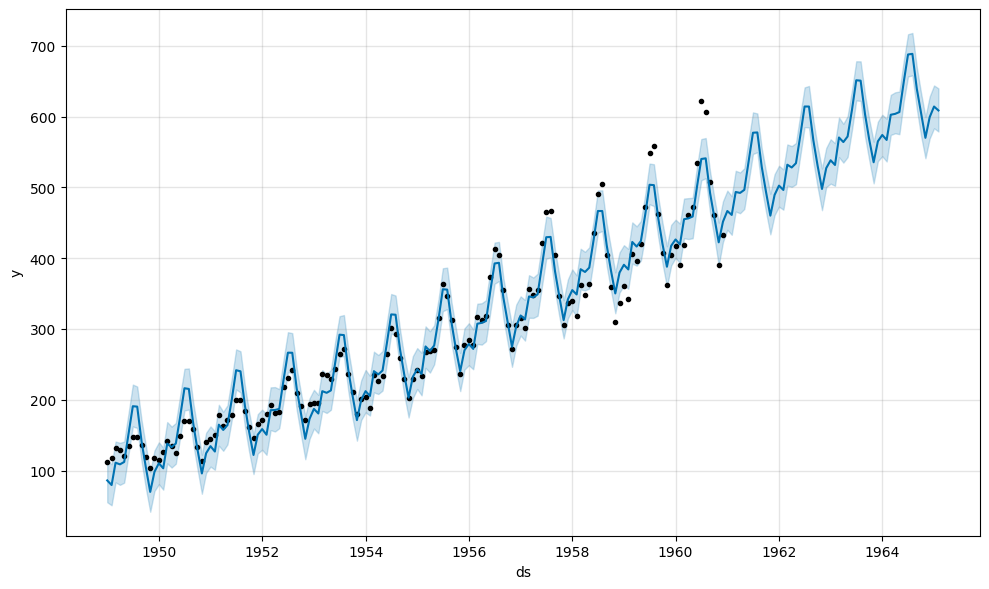

In [36]:
df = pd.read_csv('DATA/air_passengers.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

This time series has a clear yearly cycle, but the seasonality in the forecast is too large at the start of the time series and too small at the end. In this time series, the seasonality is not a constant additive factor as assumed by Prophet, rather it grows with the trend. **This is multiplicative seasonality**.

Prophet can model multiplicative seasonality by setting `seasonality_mode='multiplicative'` in the input arguments:

12:58:54 - cmdstanpy - INFO - Chain [1] start processing
12:58:54 - cmdstanpy - INFO - Chain [1] done processing


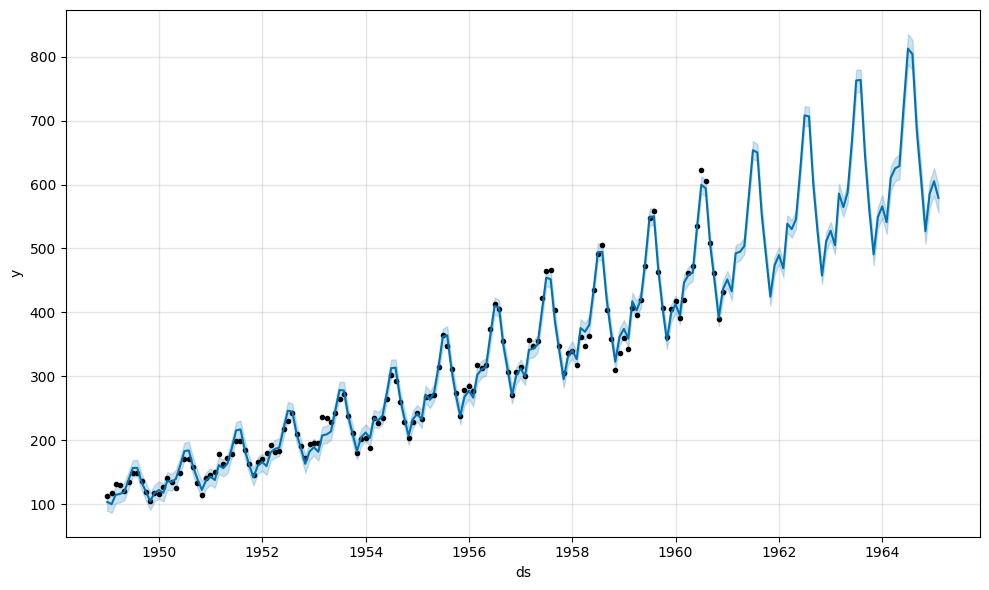

In [37]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)

The components figure will now show the seasonality as a _percent_ of the trend:

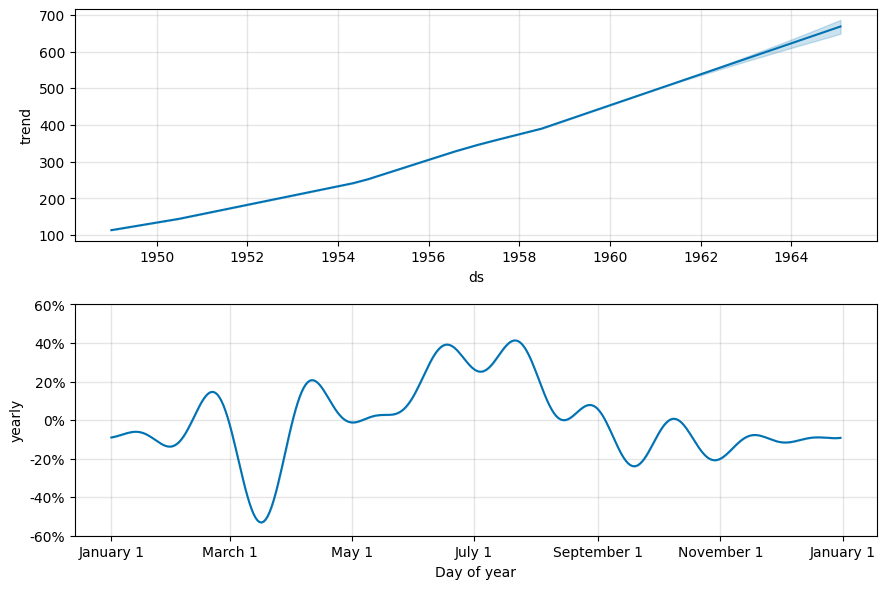

In [38]:
fig = m.plot_components(forecast)

With `seasonality_mode='multiplicative'`, _holiday effects will also_ be modeled as multiplicative. Any added seasonalities or extra regressors will by default use whatever seasonality_mode is set to, but can be overriden by specifying `mode='additive'` or `mode='multiplicative'` as an argument when adding the seasonality or regressor.

For example, this block sets the built-in seasonalities to multiplicative, but includes an additive quarterly seasonality and an additive regressor:

In [39]:
m = Prophet(seasonality_mode='multiplicative')
m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
m.add_regressor('regressor', mode='additive')

Additive and multiplicative extra regressors will show up in separate panels on the components plot. Note, however, that it is pretty unlikely to have a mix of additive and multiplicative seasonalities, so this will generally only be used if there is a reason to expect that to be the case.

# Additional Regressors

Additional regressors can be added to the linear part of the model using the `add_regressor()` method. A column with the regressor value will need to be present in both the fitting and prediction `DataFrame`.

In [40]:
#Using Auckland Cycling Data

m = Prophet(holidays=auk_holidays)
m.add_regressor('temp', standardize='auto', mode='multiplicative')
m.add_regressor('rain', standardize='auto', mode='multiplicative')
m.add_regressor('sun', standardize='auto', mode='multiplicative')
m.add_regressor('wind', standardize='auto', mode='multiplicative')

The `add_regressor` method has an optional prior scale argument (holiday prior scale will be used by default), whether or not the regressor is already standardized (or needs to be, with `standardize='auto'` as the default), and whether the regressor's effect is to be estimated with `mode='additive'` or `mode='multiplicative'`.

The extra regressor must be known for both the history and for the future dates. It thus must either be something that has known future values (i.e., such as `nfl_sunday` in the Manning data), or something that has separately been forecasted. The weather regressors are a good example of extra regressors that have weather forecasts that can be used for future values.

In [41]:
##Train
end_date_train = tamaki_df.ds.max() - np.timedelta64(365,'D')
tmk_train = tamaki_df[tamaki_df.ds <= end_date_train]
m.fit(tmk_train)

##Filtering for future data
tmk_test = m.make_future_dataframe(periods=365, include_history=False)
tmk_test = tmk_test.merge(tamaki_df, on='ds', how='inner')

12:58:55 - cmdstanpy - INFO - Chain [1] start processing
12:58:55 - cmdstanpy - INFO - Chain [1] done processing


One can also use another time series as a regressor that has been forecasted with a time series model, such as Prophet. For instance, if $r(t)$ is included as a regressor for $y(t)$, Prophet can be used to forecast $r(t)$ and then that forecast can be plugged in as the future values when forecasting $y(t)$. 

A note of caution around this approach: This will probably not be useful unless $r(t)$ is somehow easier to forecast than $y(t)$. This is because error in the forecast of $r(t)$ will produce error in the forecast of $y(t)$. One setting where this can be useful is in hierarchical time series, where there is top-level forecast that has higher signal-to-noise and is thus easier to forecast. Its forecast can be included in the forecast for each lower-level series.

Extra regressors are put in the linear component of the model, so the underlying model is that the time series depends on the extra regressor as either an additive or multiplicative factor (see the Multiplicativity section). On the components plot, the regressors' effects will show up in the `extra_regressors` plot:

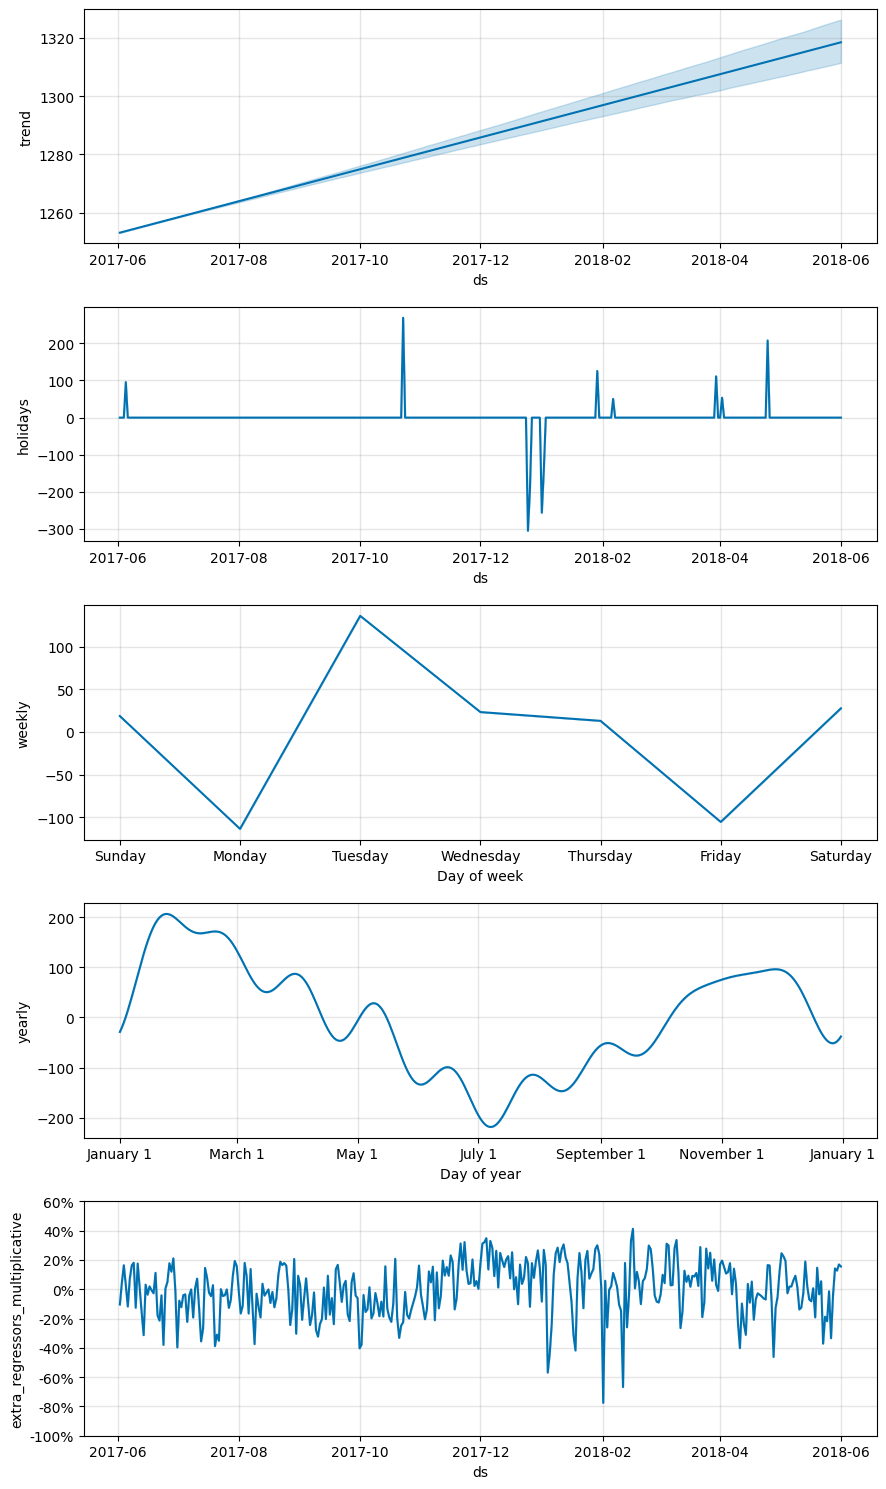

In [42]:
forecast = m.predict(tmk_test)
fig = m.plot_components(forecast)

In order to extract the coefficients of additional regressors, use the utility function `regressor_coefficients` on the fitted model. The estimated beta coefficient for each regressor roughly represents the increase in prediction value for a unit increase in the regressor value (note that the coefficients returned are always on the scale of the original data).  If `mcmc_samples` is specified, a credible interval for each coefficient is also returned, which can help identify whether the regressor is meaningful to the model (a credible interval that includes the 0 value suggests the regressor is not meaningful).

In [43]:
from prophet.utilities import regressor_coefficients

regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,temp,multiplicative,16.355542,0.009821,0.009821,0.009821
1,rain,multiplicative,0.128545,-0.201364,-0.201364,-0.201364
2,sun,multiplicative,0.420206,0.420828,0.420828,0.420828
3,wind,multiplicative,5.014971,-0.038979,-0.038979,-0.038979


# X-Validation & Hyperparam Tuning

Prophet includes functionality for time series cross-validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values. This figure illustrates a simulated historical forecast on the Peyton Manning dataset, where the model was fit to an initial history of 5 years, and a forecast was made on a one year horizon.

This cross-validation procedure can be done automatically for a range of historical cutoffs using the `cross_validation()` function. We specify the forecast horizon (`horizon`), and then optionally the size of the initial training period (`initial`) and the spacing between cutoff dates (`period`). By default, the `initial` training period is set to three times the `horizon`, and cutoffs are made every half a `horizon`.

The output of `cross_validation()` is a dataframe with the true values y and the out-of-sample forecast values `yhat`, at each simulated forecast date and for each `cutoff` date. In particular, a forecast is made for every observed point between `cutoff` and `cutoff + horizon`. This dataframe can then be used to compute error measures of `yhat` vs. `y`.

Below let us do cross-validation to assess prediction performance on a horizon of 365 days, starting with 730 days of training data in the first cutoff and then making predictions every 180 days. On this 8-year time series, this corresponds to `{m}` 11 total forecasts.

In [44]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon ='365 days')
df_cv.head()

  0%|          | 0/3 [00:00<?, ?it/s]

12:58:57 - cmdstanpy - INFO - Chain [1] start processing
12:58:57 - cmdstanpy - INFO - Chain [1] done processing
12:58:57 - cmdstanpy - INFO - Chain [1] start processing
12:58:57 - cmdstanpy - INFO - Chain [1] done processing
12:58:57 - cmdstanpy - INFO - Chain [1] start processing
12:58:57 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-06-08,1135.770750,912.909379,1344.131427,1073.0,2015-06-07
1,2015-06-09,1138.177904,928.357942,1357.829954,1295.0,2015-06-07
2,2015-06-10,1060.422709,835.925904,1276.453368,1140.0,2015-06-07
3,2015-06-11,979.302049,776.657923,1197.454381,944.0,2015-06-07
4,2015-06-12,647.176594,428.625878,868.397035,956.0,2015-06-07


Custom cutoffs can also be supplied as a list of dates to the `cutoffs` keyword in the `cross_validation()` function. For example, three `cutoffs` six months apart, would need to be passed to the cutoffs argument in a date format like:

In [45]:
cutoffs = pd.to_datetime(['2015-02-15', '2015-08-15', '2016-02-15'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

  0%|          | 0/3 [00:00<?, ?it/s]

12:58:58 - cmdstanpy - INFO - Chain [1] start processing
12:58:58 - cmdstanpy - INFO - Chain [1] done processing
12:58:58 - cmdstanpy - INFO - Chain [1] start processing
12:58:58 - cmdstanpy - INFO - Chain [1] done processing
12:58:58 - cmdstanpy - INFO - Chain [1] start processing
12:58:58 - cmdstanpy - INFO - Chain [1] done processing


The `performance_metrics()` utility can be used to compute some useful statistics of the prediction performance (`yhat`, `yhat_lower`, and `yhat_upper` compared to `y`), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE), and coverage of the `yhat_lower` and `yhat_upper` estimates. These are computed on a rolling window of the predictions in `df_cv` after sorting by horizon (`ds` minus `cutoff`). By default 10% of the predictions will be included in each window, but this can be changed with the `rolling_window` argument.

In [46]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,32302.369124,179.728599,138.173411,0.170728,0.099777,0.167291,0.813456
1,38 days,32862.079651,181.279011,140.143346,0.177508,0.099586,0.179116,0.807339
2,39 days,34099.002039,184.659151,142.667667,0.180488,0.099777,0.181796,0.788991
3,40 days,34361.184582,185.367701,143.512483,0.180864,0.099777,0.182248,0.785933
4,41 days,34072.437944,184.587210,142.718984,0.179346,0.099777,0.180360,0.785933


We can also create custom performance metric using the register_performance_metric decorator. The created metric should contain following arguments:

* `df`: Cross-validation results dataframe.

* `w`: Aggregation window size.

and return:

* Dataframe with columns `horizon` and `metric`.

In [47]:
#Cannot import, version issue?
# from prophet.diagnostics import register_performance_metric
# import numpy as np

# @register_performance_metric
# def mase(df, w):
#     """Mean absolute scale error

#         Parameters
#         ----------
#         df: Cross-validation results dataframe.
#         w: Aggregation window size.

#         Returns
#         -------
#         Dataframe with columns horizon and mase.
#     """
#     e = (df['y'] - df['yhat'])
#     d = np.abs(np.diff(df['y'])).sum()/(df['y'].shape[0]-1)
#     se = np.abs(e/d)
#     if w < 0:
#         return pd.DataFrame({'horizon': df['horizon'], 'mase': se})
#     return rolling_mean_by_h(
#         x=se.values, h=df['horizon'].values, w=w, name='mase'
#     )

# df_mase = performance_metrics(df_cv, metrics=['mase'])
# df_mase.head()


Cross validation performance metrics can be visualized with `plot_cross_validation_metric`, here shown for MAPE. Dots show the absolute percent error for each prediction in `df_cv`. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around 20% are typical for predictions, regardless of the horizon length.

/home/deck/Documents/meta-prophet-guide/.venv/lib/python3.13/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/home/deck/Documents/meta-prophet-guide/.venv/lib/python3.13/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


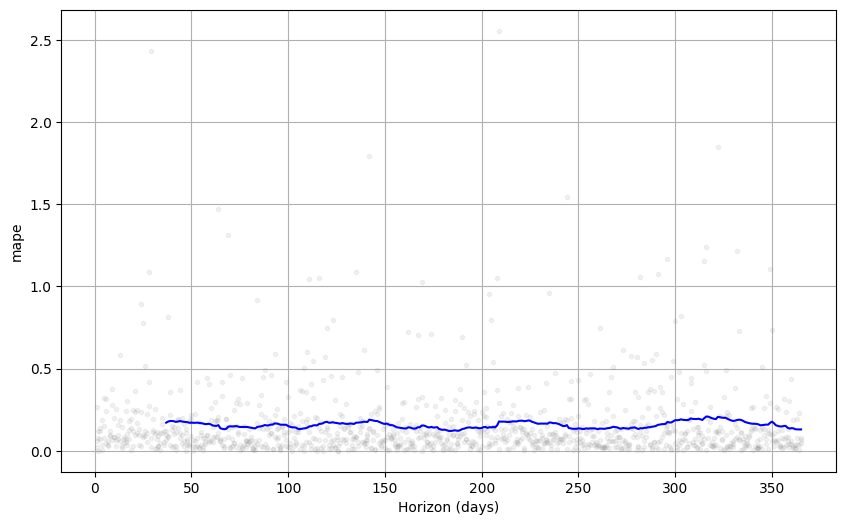

In [48]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

The size of the rolling window in the figure can be changed with the optional argument `rolling_window`, which specifies the proportion of forecasts to use in each rolling window. The default is `0.1`, corresponding to 10% of rows from `df_cv` included in each window; increasing this will lead to a smoother average curve in the figure. The initial period should be long enough to capture all of the components of the model, in particular seasonalities and extra regressors: at least a year for yearly seasonality, at least a week for weekly seasonality, etc.

### Parallelizing Cross Validation

Cross-validation can be run in parallel mode by setting the `parallel` keyword to 1 of 4 modes:

* `parallel=None` (Default)
* `parallel="processes"`: For problems that are not too big, and on a single machine.
* `parallel="threads"`: Something inbetween
* `parallel="dask"`: For larger proglems, a [Dask](https://dask.org/) can be used to do CV on multiple machines. [Dask will need to be installed separately](https://docs.dask.org/en/latest/install.html)

### Hyperparameter Optimization

Cross-validation can be used for tuning hyperparameters of the model, such as `changepoint_prior_scale` and `seasonality_prior_scale`. An example is given below, with a 4x4 grid of those two parameters, with parallelization over cutoffs. Here parameters are evaluated on RMSE averaged over a 30-day horizon, but different performance metrics may be appropriate for different problems.

In [49]:
import itertools
import numpy as np
import pandas as pd

import logging
logging.getLogger("cmdstanpy").disabled = True #  turn 'cmdstanpy' logs off
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

param_grid = {  
    'changepoint_prior_scale': np.logspace(-1, 0, num=5), #[0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': np.logspace(-2, 1, num=5), #[0.001, 0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': np.logspace(-2, 1, num=5), 
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(tamaki_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                        0.1                     0.01              0.010000   
1                        0.1                     0.01              0.010000   
2                        0.1                     0.01              0.056234   
3                        0.1                     0.01              0.056234   
4                        0.1                     0.01              0.316228   
..                       ...                      ...                   ...   
245                      1.0                    10.00              0.316228   
246                      1.0                    10.00              1.778279   
247                      1.0                    10.00              1.778279   
248                      1.0                    10.00             10.000000   
249                      1.0                    10.00             10.000000   

    seasonality_mode        rmse  
0           addi

In [50]:
# Find the best parameters
import pprint
best_params = all_params[np.argmin(rmses)]
print('Best params:\n', pprint.pformat(best_params), '\nBest RMSE: ', min(rmses))

Best params:
 {'changepoint_prior_scale': np.float64(0.1),
 'holidays_prior_scale': np.float64(0.01),
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': np.float64(0.01)} 
Best RMSE:  292.4457385190466


## List of Hyperparameters

### Commonly Tuned
* `changepoint_prior_scale`: This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. As described in this documentation, if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. The default of `0.05` works for many time series, but this could be tuned; a range of `[0.001, 0.5]` would likely be about right. Parameters like this (regularization penalties; this is effectively a lasso penalty) are often tuned on a log scale.
* `seasonality_prior_scale`: This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is `10`., which applies basically no regularization. That is because we very rarely see overfitting here (there’s inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it’s essentially low-pass filtered). A reasonable range for tuning it would probably be `[0.01, 10]`; when set to `0.01` you should find that the magnitude of seasonality is forced to be very small. This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.
* `holidays_prior_scale`: This controls flexibility to fit holiday effects. Similar to seasonality_prior_scale, it defaults to `10.0` which applies basically no regularization, since we usually have multiple observations of holidays and can do a good job of estimating their effects. This could also be tuned on a range of `[0.01, 10]` as with `seasonality_prior_scale`.
* `seasonality_mode`: Options are `['additive', 'multiplicative']`. Default is `'additive'`, but many business time series will have multiplicative seasonality. This is best identified just from looking at the time series and seeing if the magnitude of seasonal fluctuations grows with the magnitude of the time series (see the documentation here on [multiplicative seasonality](#), but when that isn’t possible, it could be tuned.

### Maybe Tune?

* `changepoint_range`: This is the proportion of the history in which the trend is allowed to change. This defaults to `0.8`, 80% of the history, meaning the model will not fit any trend changes in the last 20% of the time series. This is fairly conservative, to avoid overfitting to trend changes at the very end of the time series where there isn’t enough runway left to fit it well. With a human in the loop, this is something that can be identified pretty easily visually: one can pretty clearly see if the forecast is doing a bad job in the last 20%. In a fully-automated setting, it may be beneficial to be less conservative. It likely will not be possible to tune this parameter effectively with cross validation over cutoffs as described above. The ability of the model to generalize from a trend change in the last 10% of the time series will be hard to learn from looking at earlier cutoffs that may not have trend changes in the last 10%. So, this parameter is probably better not tuned, except perhaps over a large number of time series. In that setting, `[0.8, 0.95]` may be a reasonable range.

### Don't Tune (probably)!

* `growth`: Options are `'linear'` and `'logistic'`. This likely will not be tuned; if there is a known saturating point and growth towards that point it will be included and the logistic trend will be used, otherwise it will be linear.
* `changepoints`: This is for manually specifying the locations of changepoints. `None` by default, in which case Prophet automatically places them.
* `n_changepoints`: This is the number of automatically placed changepoints. The default of `25` should be plenty to capture the trend changes in a typical time series (at least the type that Prophet would work well on anyway). Rather than increasing or decreasing the number of changepoints, it will likely be more effective to focus on increasing or decreasing the flexibility at those trend changes, which is done with `changepoint_prior_scale`.
* `yearly_seasonality`: By default (`'auto'`) this will turn yearly seasonality on if there is a year of data, and off otherwise. Options are `['auto', True, False]`. If there is more than a year of data, rather than trying to turn this off during hyperparameter optimization, it will likely be more effective to leave it on and turn down seasonal effects by tuning `seasonality_prior_scale`.
* `weekly_seasonality`: Same as for `yearly_seasonality`.
* `daily_seasonality`: Same as for `yearly_seasonality`.
* `holidays`: This is to pass in a dataframe of specified holidays. The holiday effects would be tuned with `holidays_prior_scale`.
* `mcmc_samples`: Whether or not MCMC is used will likely be determined by factors like the length of the time series and the importance of parameter uncertainty. See the documentation on MCMC [here]().
* `interval_width`: Prophet predict returns uncertainty intervals for each component, like `yhat_lower` and `yhat_upper` for the forecast `yhat`. These are computed as quantiles of the posterior predictive distribution, and `interval_width` specifies which quantiles to use. The default of `0.8` provides an 80% prediction interval. You could change that to `0.95` if you wanted a 95% interval. This will affect only the uncertainty interval, and will not change the forecast `yhat` at all and so does not need to be tuned.
* `uncertainty_samples`: The uncertainty intervals are computed as quantiles from the posterior predictive interval, and the posterior predictive interval is estimated with Monte Carlo sampling. This parameter is the number of samples to use (defaults to `1000`). The running time for predict will be linear in this number. Making it smaller will increase the variance (Monte Carlo error) of the uncertainty interval, and making it larger will reduce that variance. So, if the uncertainty estimates seem jagged this could be increased to further smooth them out, but it likely will not need to be changed. As with `interval_width`, this parameter only affects the uncertainty intervals and changing it will not affect in any way the forecast `yhat`; it does not need to be tuned.

# Uncertainty Intervals

By default Prophet will return uncertainty intervals for the forecast `yhat`. There are several important assumptions behind these uncertainty intervals (see emphasis below). 

There are three sources of uncertainty in the forecast: **uncertainty in the trend**, **uncertainty in the seasonality estimates**, and additional observed noise.

## Uncertainty in the Trend

The biggest source of uncertainty in the forecast is the potential for future trend changes. The time series we have seen already in this documentation show clear trend changes in the history. Prophet is able to detect and fit these, but what trend changes should we expect moving forward? It’s impossible to know for sure, so we do the most reasonable thing we can, and _we assume that the future will see similar trend changes as the history_. In particular, we assume that the average frequency and magnitude of trend changes in the future will be the same as that which we observe in the history. We project these trend changes forward and by computing their distribution we obtain uncertainty intervals.

One property of this way of measuring uncertainty is that allowing higher flexibility in the rate, by increasing `changepoint_prior_scale`, will increase the forecast uncertainty. This is because if we model more rate changes in the history then we will expect more in the future, and makes the **uncertainty intervals a useful indicator of overfitting**.

The width of the uncertainty intervals (by default 80%) can be set using the parameter `interval_width`:

In [51]:
forecast = Prophet(interval_width=0.95).fit(df).predict(future)

Again, these **intervals assume that the future will see the same frequency and magnitude of rate changes as the past. This assumption is probably not true**, so you should not expect to get accurate coverage on these uncertainty intervals.

## Uncertainty in Seasonality

**By default Prophet will only return uncertainty in the trend and observation noise**. To get uncertainty in seasonality, you must do full Bayesian sampling. This is done using the parameter `mcmc.samples` (which defaults to `0`). We do this here for the first six months of the Peyton Manning data from the Quickstart:

In [56]:
m = Prophet(mcmc_samples=300)
forecast = m.fit(man_df, show_progress=False).predict(ftr_man_df)

This replaces the typical MAP estimation with **MCMC sampling, and can take much longer depending on how many observations there are - expect several minutes instead of several seconds**. If you do full sampling, then you will see the uncertainty in seasonal components when you plot them:

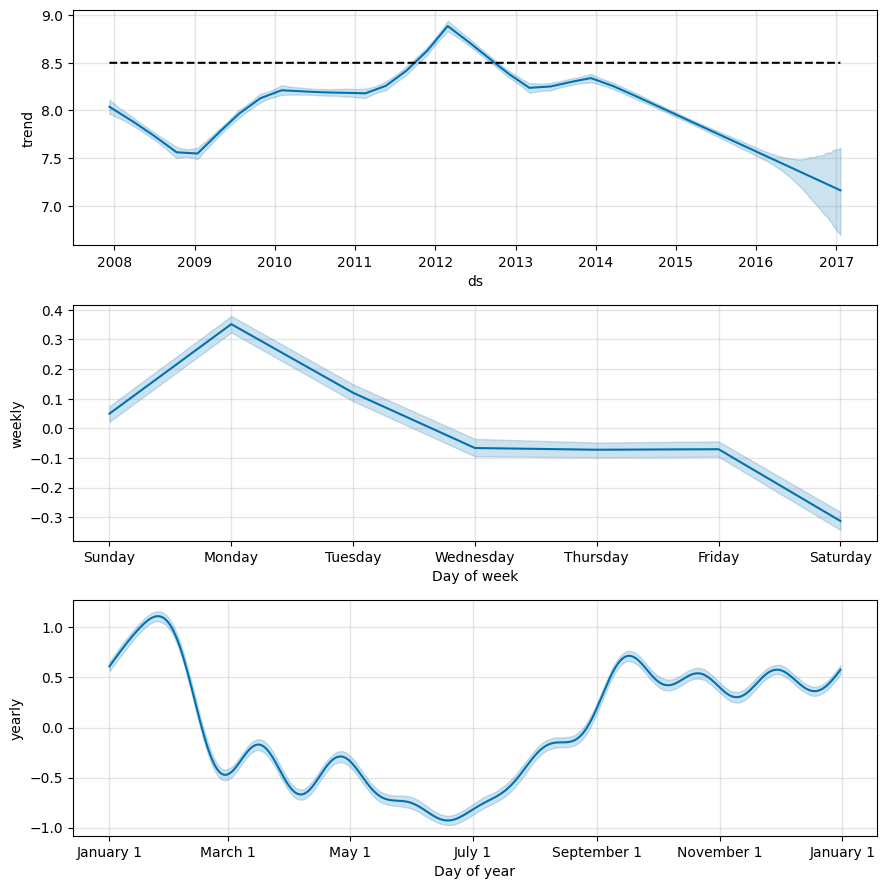

In [57]:
fig = m.plot_components(forecast)

You can access the raw posterior predictive samples using the method `m.predictive_samples(future)`.

# References

- Prophet -- Getting Started Guide: [https://facebook.github.io/prophet/docs/quick_start.html](https://facebook.github.io/prophet/docs/quick_start.html)
- Taylor & Letham Paper -- Facebook -- Inventors of Prophet: [https://peerj.com/preprints/3190/](https://peerj.com/preprints/3190/)

## Misc

- Auckland Cycling: The Impact of Weather Conditions on Cyclist Counts -- Aquired datasets and examples for additional regressors in Prophet models -- [https://github.com/nicolasfauchereau/Auckland_Cycling](https://github.com/nicolasfauchereau/Auckland_Cycling)
- Payton Manning Data: https://github.com/facebook/prophet/blob/main/examples/example_wp_log_peyton_manning.csv
- Python `holidays` package: [https://github.com/vacanza/python-holidays/](https://github.com/vacanza/python-holidays/)
- Wikipedia Article on Fourier Series: [https://en.wikipedia.org/wiki/Fourier_series#](https://en.wikipedia.org/wiki/Fourier_series#)
- Multiplicative Seasonality Trend Data - Airline Passengers, USA: [https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv](https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv)